# DHCG Tunability Optimization

> Optimizate tunability; defined as distance between peaks divided by average FWHM

Conditions
- SiO2 Thickness under 3um
- Graphene Fermi energy between 0.05eV and 0.6eV
- Si thickness under 1um
- P shorter than wavelength (suppress diffraction)

Optimization Method
- Gradient Descent

In [ ]:
import matplotlib.pyplot as plt
from util_n import *
from util_opt import *
from util_meent import *


In [2]:
list_tun = []

In [3]:
max_tun = 0
tmp_tun = 0
best_parameters = [0,0,0,0,0]


for i in range(30):

    print("-------------------")
    print(i+1, "th Trial")
    print("-------------------")

    p, delta, d, t, w, fom = find_BIC()

    if p is None:
        continue

    parameters = [p.item(), delta.item(), d.item(), t.item(), w.item()]

    p, delta, d, t, w, tmp_tun = find_tun(parameters)

    if p is None:
        continue

    if tmp_tun>max_tun and tmp_tun < 3:
        best_parameters = [p.item(), delta.item(), d.item(), t.item(), w.item()]
        max_tun = tmp_tun
    
    print("Obtained Tunability: ", tmp_tun,"Max Tunability: ", max_tun, "                                                                               ")

    list_tun.append(tmp_tun)

-------------------
1 th Trial
-------------------


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\meent\on_torch\modeler\modeling.py:76: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:276.)
  lx = lx.type(self.type_float)


Obtained Tunability:  1.7230666743549108 Max Tunability:  1.7230666743549108                                                                                5556014452998 Gradients - p: 0.20373645579081984, delta: -628.0567464670032, d: 0.1891275242736258, t: 0.6986600857829188, w: 0.269377154175337280435
-------------------
2 th Trial
-------------------
Obtained Tunability:  1.825781481782293 Max Tunability:  1.825781481782293                                                                                .2350213828154 Gradients - p: 0.2018359461839482, delta: -585.5683672135184, d: -0.05094966189834762, t: -0.5037703243978089, w: -0.2079005415302757313
-------------------
3 th Trial
-------------------
Obtained Tunability:  1.6619270042247445 Max Tunability:  1.825781481782293                                                                                9.634440704329 Gradients - p: 0.10134756728315752, delta: -279.0180524181975, d: 0.002662152608280463, t: -0.420430287327119, w: -0

In [4]:
list_tun_3_5 = np.array(list_tun)

p = torch.tensor(best_parameters[0], requires_grad=True, dtype=torch.float64)
delta = torch.tensor(best_parameters[1], requires_grad=True, dtype=torch.float64)
d = torch.tensor(best_parameters[2], requires_grad=True, dtype=torch.float64)
t = torch.tensor(best_parameters[3], requires_grad=True, dtype=torch.float64)
w = torch.tensor(best_parameters[4], requires_grad=True, dtype=torch.float64)

print(p,t,w,delta,d)

tensor(2906.0007, dtype=torch.float64, requires_grad=True) tensor(296.7965, dtype=torch.float64, requires_grad=True) tensor(1186.5322, dtype=torch.float64, requires_grad=True) tensor(0.0426, dtype=torch.float64, requires_grad=True) tensor(1651.8897, dtype=torch.float64, requires_grad=True)


In [5]:
p = torch.round(p, decimals=-1)
t = torch.round(t)
w = torch.round(w, decimals= -1)
d = torch.round(d, decimals = -1)
delta = torch.round(delta, decimals = 3)
        
period_x = 2* p
period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)
center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
length_x = [ w, w, period_x, period_x, period_x]
length_y = [ period_y, period_y, period_y, period_y, period_y]

print(p,t,w,delta,d)

print("p: ", p.item())
print("delta: ", delta.item())
print("t: ", t.item())
print("w: ", w.item())
print("d: ", d.item())

tensor(2910., dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(297., dtype=torch.float64, grad_fn=<RoundBackward0>) tensor(1190., dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(0.0430, dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(1650., dtype=torch.float64, grad_fn=<RoundBackward1>)
p:  2910.0
delta:  0.043
t:  297.0
w:  1190.0
d:  1650.0


In [6]:
wavelengths = torch.linspace(5000, 7000, 500) 

reflectances_after_005eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_005eV[i] = de_ri.sum()

reflectances_after_060eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_060eV[i] = de_ri.sum()


y_005_af = reflectances_after_005eV.detach().numpy()
y_060_af = reflectances_after_060eV.detach().numpy()

In [7]:
reflectances_after_005eV_withloss = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si-0.067j , n_Si-0.067j, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_005eV_withloss[i] = de_ri.sum()

reflectances_after_060eV_withloss = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si-0.067j, n_Si-0.067j, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_060eV_withloss[i] = de_ri.sum()


y_005_loss = reflectances_after_005eV_withloss.detach().numpy()
y_060_loss = reflectances_after_060eV_withloss.detach().numpy()

In [8]:
delta = torch.tensor(0.00, requires_grad=True, dtype=torch.float64)
center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
length_x = [ w, w, period_x, period_x, period_x]
length_y = [ period_y, period_y, period_y, period_y, period_y]

reflectances_0del_005eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_0del_005eV[i] = de_ri.sum()

    #wavelengths = torch.tensor([5500], dtype=torch.float64)

reflectances_0del_060eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_0del_060eV[i] = de_ri.sum()

x_np = wavelengths.numpy()
y_005_0del = reflectances_0del_005eV.detach().numpy()
y_060_0del = reflectances_0del_060eV.detach().numpy()

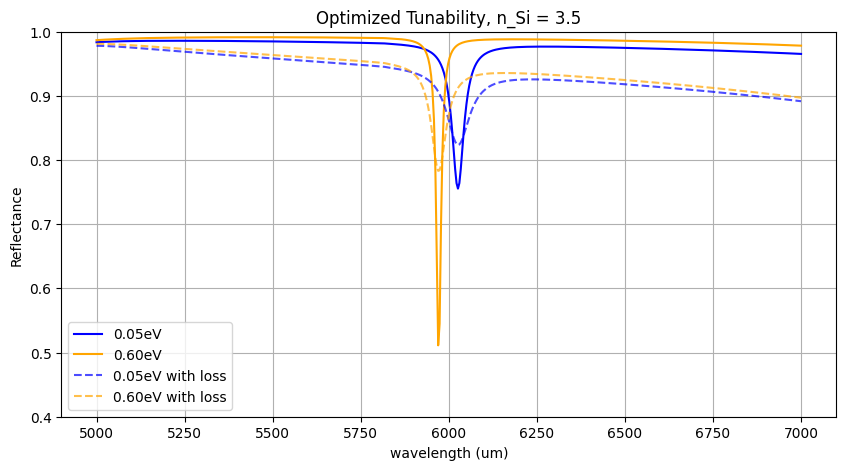

In [9]:
# Plotting with matplotlib
plt.figure(figsize=(10, 5))
plt.plot(x_np, y_005_af, label='0.05eV', color='blue')
plt.plot(x_np, y_060_af, label='0.60eV',color='orange')
plt.plot(x_np, y_005_loss, label='0.05eV with loss', color='blue', ls = '--', alpha = 0.7)
plt.plot(x_np, y_060_loss, label='0.60eV with loss', color='orange', ls = '--', alpha = 0.7)
plt.title("Optimized Tunability, n_Si = 3.5")
plt.xlabel('wavelength (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)
plt.ylim([0.4,1])
plt.show()

In [10]:
tun = tunability(best_parameters)

print(tun)

Peak wavelengths:  6019.59228515625 5964.36962890625
FWHM:  7.62715216053012e-06 2.7205056073750875e-06
1.867886388186957
